## Deep Deterministic Policy Gradiant: DDPG  in pendulum

In [2]:
import gym

# 定义环境
class MyWrapper(gym.Wrapper):
  def __init__(self):
    env = gym.make('Pendulum-v1', render_mode='rgb_array')
    super().__init__(env)
    self.env = env
    self.step_n = 0
  
  def reset(self):
    state, _ = self.env.reset()
    self.step_n = 0
    return state
    
  def step(self, action):
    state, reward, terminated, truncated, info = self.env.step(action)
    done = terminated or truncated
    self.step_n += 1
    if self.step_n >= 200:
      done = True
    return state, reward, done, info 
  
env = MyWrapper()
env.reset()

array([ 0.9907573 , -0.13564652, -0.31195584], dtype=float32)

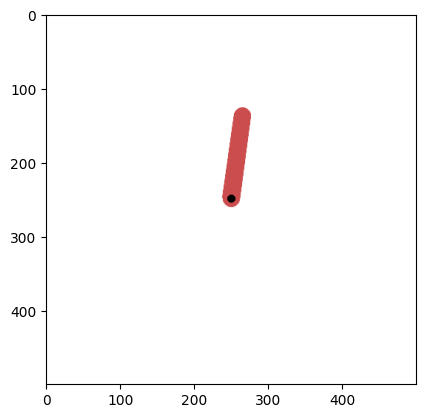

In [3]:
from matplotlib import pyplot as plt

%matplotlib inline

# 打印游戏
def show():
  plt.imshow(env.render())
  plt.show()
  
show()

In [5]:
import torch

# 定义模型
class Model(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.sequential = torch.nn.Sequential(
      torch.nn.Linear(3, 64),
      torch.nn.ReLU(),
      torch.nn.Linear(64, 64),
      torch.nn.ReLU(),
      torch.nn.Linear(64, 1),
      torch.nn.Tanh(),
    )
    
  def forward(self, state):
    return self.sequential(state) * 2.0

model_action = Model()
model_action_next = Model()

model_action_next.load_state_dict(model_action.state_dict())

model_action(torch.randn(1, 3))

tensor([[0.1094]], grad_fn=<MulBackward0>)

In [6]:
model_value = torch.nn.Sequential(
  torch.nn.Linear(4, 64),
  torch.nn.ReLU(),
  torch.nn.Linear(64, 64),
  torch.nn.ReLU(),
  torch.nn.Linear(64, 1),
)

model_value_next = torch.nn.Sequential(
  torch.nn.Linear(4, 64),
  torch.nn.ReLU(),
  torch.nn.Linear(64, 64),
  torch.nn.ReLU(),
  torch.nn.Linear(64, 1),
)

model_value_next.load_state_dict(model_value.state_dict())

model_value(torch.randn(1, 4))

tensor([[-0.0166]], grad_fn=<AddmmBackward0>)

In [ ]:
import random
import numpy as np 

# 得到一个动作
def get_action(state):
  # 走神经网络，得到一个动作
  state = torch.FloatTensor(state).reshape(1, 3)
  action = model_action(state).item()
  # 增加噪声作为探索
  action += random.normalvariate(mu=0, sigma=0.01)
  return action

get_action([1, 2, 3])

0.6358529471571284

In [8]:
# 样本池
datas = []

def update_data():
  state = env.reset()
  
  # 玩到结束
  over = False
  while not over:
    action = get_action(state)
    
    next_state, reward, over, _ = env.step([action])
    
    datas.append((state, action, reward, next_state, over))
    
    state = next_state
    
  while len(datas) > 10000:
    datas.pop(0)
    
update_data()

len(datas), datas[0]

(200,
 (array([0.64718384, 0.762334  , 0.0779994 ], dtype=float32),
  0.17261362244120607,
  -0.7521743513515019,
  array([0.6210662 , 0.7837581 , 0.67564195], dtype=float32),
  False))

In [14]:
# 获取一批数据样本
def get_sample():
  # 从样本池中采样
  samples = random.sample(datas, 64)
  
  # [b, 3]
  state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 3)
  # [b, 1]
  action = torch.FloatTensor([i[1] for i in samples]).reshape(-1, 1)
  # [b, 1]
  reward = torch.FloatTensor([i[2] for i in samples]).reshape(-1, 1)
  # [b, 3]
  next_state = torch.FloatTensor([i[3] for i in samples]).reshape(-1, 3)
  # [b, 1]
  over = torch.LongTensor([i[4] for i in samples]).reshape(-1, 1)
  
  return state, action, reward, next_state, over

state, action, reward, next_state, over = get_sample()

state[:5], action[:5], reward[:5], next_state[:5], over[:5]

(tensor([[ 0.0998, -0.9950,  6.0456],
         [ 0.9057, -0.4239,  3.1504],
         [-0.9962, -0.0876, -7.4009],
         [ 0.9940, -0.1096,  2.7138],
         [ 0.9646,  0.2636,  2.8436]]),
 tensor([[ 0.0851],
         [ 0.2411],
         [-0.1909],
         [ 0.2903],
         [ 0.3769]]),
 tensor([[ -5.8183],
         [ -1.1842],
         [-14.8038],
         [ -0.7486],
         [ -0.8799]]),
 tensor([[ 0.3575, -0.9339,  5.3121],
         [ 0.9570, -0.2901,  2.8686],
         [-0.9591,  0.2832, -7.4952],
         [ 0.9997,  0.0239,  2.6751],
         [ 0.9124,  0.4093,  3.0979]]),
 tensor([[0],
         [0],
         [0],
         [0],
         [0]]))

In [15]:
from IPython import display

def test(play):
  #初始化游戏
  state = env.reset()
  
  #记录反馈值的和,这个值越大越好
  reward_sum = 0
  
  #玩到游戏结束为止
  over = False
  while not over:
    #根据当前状态得到一个动作
    action = get_action(state)
    
    #执行动作,得到反馈
    state, reward, over, _ = env.step([action])
    reward_sum += reward
    
    # 打印动画
    if play and random.random() < 0.2: # 跳帧
      display.clear_output(wait=True)
      show()
      
  return reward_sum

test(play=False)

-1254.533422420098

In [18]:
def get_value(state, action):
  # 直接评估综合了state和action的value
  # [b, 3 + 1] -> [b, 4]
  input = torch.cat([state, action], dim=1)
  
  # [b, 4] -> [b, 1]
  return model_value(input)

def get_target(next_state, reward, over):
  # 对next_state 的评估需要先把它对应的动作计算出来，这里用model_action_next来计算
  # [b, 3] -> [b, 1]
  action = model_action_next(next_state)
  
  # 和value的计算一样，action拼合进next_state
  # [b, 3 + 1] -> [b, 4]
  input = torch.cat([next_state, action], dim=1)
  
  # [b, 4] -> [b, 1]
  target = model_value_next(input) * 0.98
  
  # [b, 1] * [b, 1] -> [b, 1]
  target *= (1 - over)
  
  # [b, 1] + [b, 1] -> [b, 1]
  target += reward
  
  return target

get_value(state, action)[:5], get_target(next_state, reward, over)[:5]

(tensor([[ 1.0034e-02],
         [ 3.1280e-02],
         [-9.9666e-03],
         [ 2.0110e-02],
         [-9.3386e-05]], grad_fn=<SliceBackward0>),
 tensor([[ -5.7971],
         [ -1.1566],
         [-14.8165],
         [ -0.7346],
         [ -0.8881]], grad_fn=<SliceBackward0>))

In [19]:
def get_loss_action(state):
  # 首先计算动作
  # [b, 3] -> [b, 1]
  action = model_action(state)
  
  # 像value计算那里一样，拼合state和acton综合计算
  # [b, 3 + 1] -> [b, 4]
  input = torch.cat([state, action], dim=1)
  
  # 使用网络评估动作价值，价值越高越好
  # 价值越高，loss越小，
  # [b, 4] -> [b, 1] -> [1]
  loss = -model_value(input).mean()
  
  return loss

get_loss_action(state)

tensor(0.0330, grad_fn=<NegBackward0>)

In [20]:
def soft_update(model, model_next):
  for param, param_next in zip(model.parameters(), model_next.parameters()):
    # 以一个小比例更新
    value = param_next.data * 0.995 + param.data * 0.005
    param_next.data.copy_(value)
    
soft_update(torch.nn.Linear(4, 64), torch.nn.Linear(4, 64))

In [21]:
def train():
  model_action.train()
  model_value.train()
  optimizer_action = torch.optim.Adam(model_action.parameters(), lr=5e-4)
  optimizer_value = torch.optim.Adam(model_value.parameters(), lr=5e-3)
  loss_fn = torch.nn.MSELoss()
  
  # 玩N局游戏，每句游戏训练一次
  for epoch in range(200):
    # 更新N条数据
    update_data()
    
    # 每次更新过后，学习N次
    for i in range(200):
      # 采样一批数据
      state, action, reward, next_state, over = get_sample()
      
      # 计算value和target
      value = get_value(state, action)
      target = get_target(next_state, reward, over)
      
      # 求差，计算loss, 更新参数
      loss_value = loss_fn(value, target)
      
      optimizer_value.zero_grad()
      loss_value.backward()
      optimizer_value.step()
      
      # 使用value网络评估action网络的loss, 更新参数
      loss_action = get_loss_action(state)
      
      optimizer_action.zero_grad()
      loss_action.backward()
      optimizer_action.step()
      
      # 小比例更新
      soft_update(model_action, model_action_next)
      soft_update(model_value, model_value_next)
      
    if epoch % 20 == 0:
      test_result = sum([test(play=False) for _ in range(10)]) / 10
      print(epoch, len(datas), test_result)
      
train()

0 400 -1666.9655100675614
20 4400 -1011.609982571709
40 8400 -1026.213337137478
60 10000 -888.042446341991
80 10000 -237.94136840537072
100 10000 -196.89120242090263
120 10000 -120.97536023142997
140 10000 -178.04878409834123
160 10000 -129.91273884185952
180 10000 -132.08058878771524


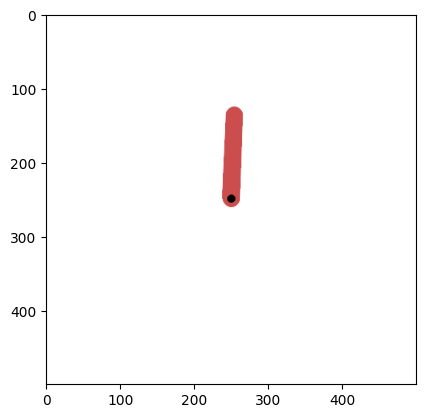

-116.51879707573413

In [22]:
test(play=True)